# Side-Channel Power Analysis Lab: CPA & Monobit DPA Attacks on AES

- This notebook contains a walkthrough / Proof-of-Concepts for two Power Analysis attacks, specifically **Correlation Power Analysis (CPA)** and **Monobit Differential Power Analysis (DPA)**
- The goal is to...
   - Understand how these attacks exploit power consumption to recover AES keys
   - Analyze real power traces from an AES device
   - Perform both CPA and Monobit DPA attacks to recover the AES key used to encrypt a secret message
   - Decrypt the message using your recovered key



## What are Power Analysis Attacks?

**Power analysis attacks** are a type of side-channel attacks that aim to exploit a **relationship between the input to a cryptographic device and its power consumption** (this is the side channel). By measuring and analyzing the power traces during encryption or decryption, attackers can extract secret information: namely cryptographic keys!

### Correlation Power Analysis (CPA)

**CPA** is a powerful statistical attack that uses a model (like Hamming Weight) to predict how the device's power consumption correlates with **intermediate values** (that are dependent on the key) during encryption. By comparing the predicted power consumption for all possible key guesses with the actual measured traces, the attacker can identify the correct key as the one with the **highest correlation.**

### Differential Power Analysis (DPA) and Monobit DPA

**DPA** is another statistical technique that looks for differences in power consumption based on single bits of intermediate values. **Monobit DPA** focuses on the value of a single bit (0 or 1) in the intermediate computation, and checks how the power traces differ depending on that bit. By repeating this for all bits, the attacker can reconstruct the key byte by byte.



## Challenge

**We're trying to crack this message:**

`e6fcd181802b4619f933f5b3722bd6c385b30882ca98866c0328e5dbcdaa4a99`

It was encrypted using AES-128 in ECB mode with a key that you will recover using CPA and Monobit DPA attacks on the provided traces!



## 1. Setup & Imports

Importing required libraries and setting up helper functions. Notably, we will be relying on the `scared` library to carry out both attacks. 

In [1]:
# Install pycryptodome if needed
!pip install pycryptodome scared --quiet

import numpy as np
import matplotlib.pyplot as plt
from scared import aes
import scared
import binascii
from Crypto.Cipher import AES

def np_to_hex(np_arr):
    return ''.join(f"{dec:02x}" for dec in np_arr)



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# (Spoilers) Generate Challenge

In [2]:
# Encrypt and decrypt a sample message using the correct AES key

from Crypto.Cipher import AES

# The correct AES key we're trying to find (hex string)
key_hex = "d1310ba698dfb5ac2ffd72dbd01adfb7"
key_bytes = bytes.fromhex(key_hex)

# Sample message (has to be multiple of 16 bytes for AES ECB, so we pad it)
sample_message = "TaylorSwift 4EVA" #feel free to change this message

# PKCS#7 padding
pad_len = 16 - (len(sample_message) % 16)
padded_message = sample_message.encode('utf-8') + bytes([pad_len] * pad_len)

# Encrypt
aes_ecb = AES.new(key_bytes, AES.MODE_ECB)
ciphertext = aes_ecb.encrypt(padded_message)
print("Ciphertext (hex):", ciphertext.hex())

# Decrypt
decrypted = aes_ecb.decrypt(ciphertext)
unpadded = decrypted[:-decrypted[-1]]
print("Decrypted message:", unpadded.decode('utf-8'))

Ciphertext (hex): e6fcd181802b4619f933f5b3722bd6c385b30882ca98866c0328e5dbcdaa4a99
Decrypted message: TaylorSwift 4EVA


## 2. Load Power Traces

The traces are stored in files with metadata for key, plaintext, and ciphertext. 

In [3]:
metadata = {
    'key': scared.traces.bin_extractor.PatternExtractor(r"([A-Fa-f0-9]{32})", num=0),
    'plain': scared.traces.bin_extractor.PatternExtractor(r"([A-Fa-f0-9]{32})", num=1),
    'cipher': scared.traces.bin_extractor.PatternExtractor(r"([A-Fa-f0-9]{32})", num=2)
}

ths = scared.traces.read_ths_from_bin_filenames_pattern(
    './dataset_01/traces/*.bin',
    dtype='int16',
    metadatas_parsers=metadata
)
print(f"Loaded {len(ths)} traces.") # max number of traces we can use

Loaded 20000 traces.


## 3. Visualize Example Traces

Let's plot a few traces to see what the power consumption looks like during AES operations.

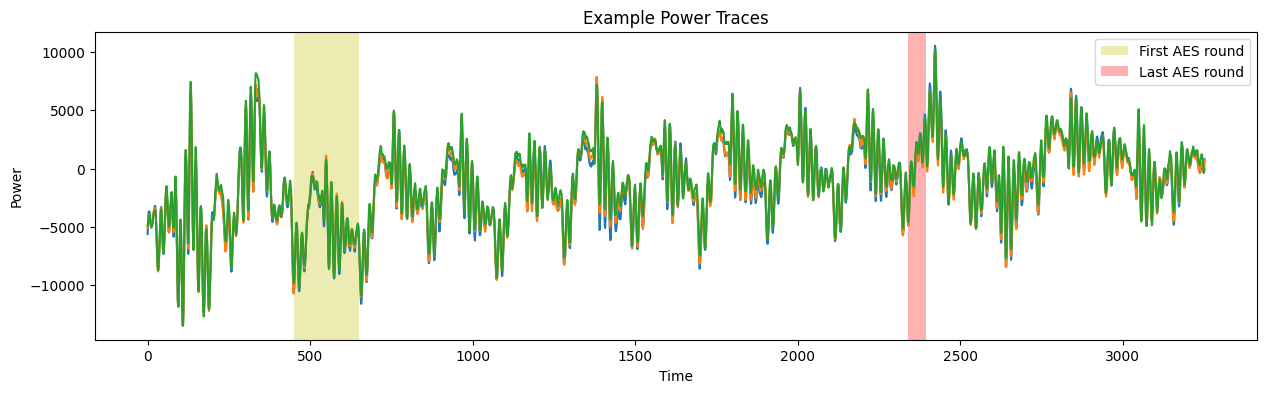

In [4]:
plt.figure(figsize=(15,4))
plt.title('Example Power Traces')
plt.xlabel('Time')
plt.ylabel('Power')
plt.plot(ths.samples[0:3].T)
plt.axvspan(450, 650, facecolor='y', alpha=0.3, label='First AES round')
plt.axvspan(2340, 2395, facecolor='r', alpha=0.3, label='Last AES round')
plt.legend()
plt.show()

## 4. Define the CPA Attack

We'll target the last round of AES to recover the last round key. The following function is used by the CPA attack to model the intermediate values.

In [5]:
@scared.attack_selection_function # reference: scared Libary documentation
def delta_last_two_rounds(cipher, guesses):
    res = np.empty((cipher.shape[0], len(guesses), cipher.shape[1]), dtype='uint8')
    for i, guess in enumerate(guesses):
        s = aes.inv_sub_bytes(state=np.bitwise_xor(cipher, guess))
        res[:, i, :] = np.bitwise_xor(aes.shift_rows(cipher), s)
    return res

## 5. Run the CPA Attack

Let's run the CPA attack using all available traces and recover the last round key.

In [6]:

def np_to_hex(np_arr): # convert numpy array to hex string
    return ''.join(f"{dec:02x}" for dec in np_arr)

NUM_OF_TRACES = len(ths)
print(f"PERFORMING CPA ATTACK W/ {NUM_OF_TRACES} TRACES")

last_rounds_container = scared.Container(ths[:NUM_OF_TRACES], frame=slice(2340, 2395))

cpa_attack = scared.CPAAttack(
    selection_function=delta_last_two_rounds,
    model=scared.HammingWeight(), # use HammingWeight
    discriminant=scared.maxabs,
    convergence_step=1000
)

cpa_attack.run(last_rounds_container)

expected_last_key = aes.key_schedule(key=ths[0].key)[-1]
cpa_last_key = np.argmax(cpa_attack.scores, axis=0)
print(f"Expected Last Round Key: {np_to_hex(expected_last_key)}")
print(f"Recovered Last Round Key: {np_to_hex(cpa_last_key)}")

PERFORMING CPA ATTACK W/ 20000 TRACES
Expected Last Round Key: 6ecb06a3721a2bffe5e8ef12ff7edccc
Recovered Last Round Key: 6ecb06a3721a2bffe5e8ef12ff7edccc


## 6. Visualize CPA Results

Let's plot the CPA correlation for the last byte of the key, and see how the attack converges as we add more traces.

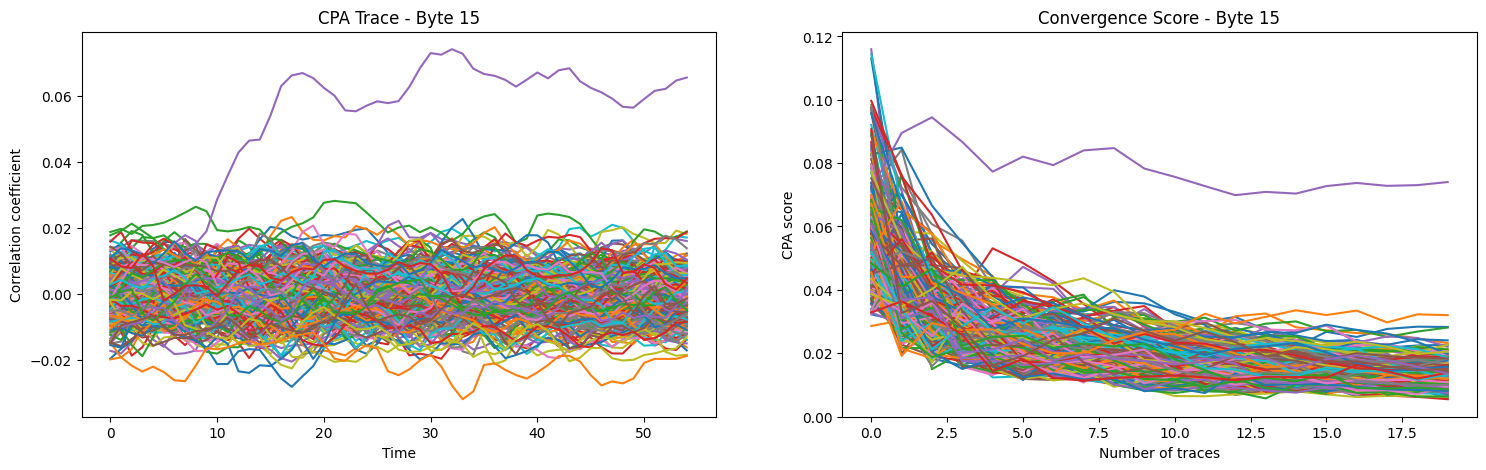

In [7]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.title('CPA Trace - Byte 15')
plt.xlabel('Time')
plt.ylabel('Correlation coefficient')
plt.plot(cpa_attack.results[:, 15, :].T)

plt.subplot(1,2,2)
plt.title('Convergence Score - Byte 15')
plt.xlabel('Number of traces')
plt.ylabel('CPA score')
plt.plot(cpa_attack.convergence_traces[:, 15, :].T)
plt.show()

# 7. Monobit DPA Attack

In [8]:

# --- Monobit DPA Attack Section ---
print("\n----- Running Monobit DPA Attack (all bits 0-7) -----")
max_scores = None
for b in range(8):
    print(f"Running Monobit DPA for bit {b}...")
    dpa_attack = scared.DPAAttack(
        selection_function=delta_last_two_rounds,
        model=scared.Monobit(b),
        discriminant=scared.maxabs
    )
    dpa_attack.run(last_rounds_container)
    if max_scores is None:
        max_scores = np.copy(dpa_attack.scores)
    else:
        max_scores = np.maximum(max_scores, dpa_attack.scores)

dpa_key = np.argmax(max_scores, axis=0)
print("DPA Last Round Key:", dpa_key)
print("Expected Last Round Key:", expected_last_key)
print("DPA Attack Success:", np.array_equal(dpa_key, expected_last_key))
print("DPA Last Round Key (hex):", np_to_hex(dpa_key))


----- Running Monobit DPA Attack (all bits 0-7) -----
Running Monobit DPA for bit 0...
Running Monobit DPA for bit 1...
Running Monobit DPA for bit 2...
Running Monobit DPA for bit 3...
Running Monobit DPA for bit 4...
Running Monobit DPA for bit 5...
Running Monobit DPA for bit 6...
Running Monobit DPA for bit 7...
DPA Last Round Key: [110 203   6 163 114  26  43 255 229 232 239  18 255 126 220 204]
Expected Last Round Key: [110 203   6 163 114  26  43 255 229 232 239  18 255 126 220 204]
DPA Attack Success: True
DPA Last Round Key (hex): 6ecb06a3721a2bffe5e8ef12ff7edccc


## 8. Recover the Original AES Key

The CPA and/or DPA attack gives us the last round key. Let's invert the AES key schedule to recover the original key.

In [9]:
inverted_key = scared.aes.base.inv_key_schedule(cpa_last_key, round_in=10)
recovered_aes_key = inverted_key[0][0]
print(f"Recovered AES Key: {np_to_hex(recovered_aes_key)}")

Recovered AES Key: d1310ba698dfb5ac2ffd72dbd01adfb7


## 9. Decrypt the Challenge Message

Now, let's use the recovered key to decrypt the challenge ciphertext!

In [13]:
challenge_ciphertext_hex = ciphertext.hex()
print("Challenge ciphertext (hex):", challenge_ciphertext_hex)
challenge_ciphertext = bytes.fromhex(challenge_ciphertext_hex)
recovered_key_bytes = bytes(recovered_aes_key)

aes_ecb = AES.new(recovered_key_bytes, AES.MODE_ECB)
decrypted = aes_ecb.decrypt(challenge_ciphertext)
print("Decrypted message (raw bytes):", decrypted)
try:
    # Remove the PKCS#7 padding we previously added
    pad_len = decrypted[-1]
    unpadded = decrypted[:-pad_len]
    print("Decrypted message (utf-8):", unpadded.decode('utf-8'))
except Exception as e:
    print("Could not decode decrypted message:", e)

print("Unpadded (hex):", unpadded.hex())

Challenge ciphertext (hex): e6fcd181802b4619f933f5b3722bd6c385b30882ca98866c0328e5dbcdaa4a99
Decrypted message (raw bytes): b'TaylorSwift 4EVA\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10'
Decrypted message (utf-8): TaylorSwift 4EVA
Unpadded (hex): 5461796c6f7253776966742034455641


## 10. Summary

Thank you for viewing my project!

References:
- The [Scared] Library (https://eshard.gitlab.io/scared/guides/dpa_v2_attack.html)
- https://www.allaboutcircuits.com/technical-articles/a-basic-introduction-to-power-based-side-channel-attacks/
- https://yan1x0s.medium.com/side-channel-attacks-part-2-dpa-cpa-applied-on-aes-attack-66baa356f03f